# FastGAN
- En este notebook se define una arquitectura basada en [FastGAN](https://arxiv.org/abs/2101.04775).
- El código completo en Tensorflow se encuentra en [este repositorio](https://github.com/milmor/self-supervised-gan).

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable tensorflow debugging logs
import tensorflow as tf
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np
import time

AUTOTUNE = tf.data.experimental.AUTOTUNE

- Descarga dataset

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images = (train_images - 127.5) / 127.5 
test_images = (test_images - 127.5) / 127.5 

## 1.- Pipeline

In [3]:
def deprocess(img):
    return img * 127.5 + 127.5

In [4]:
def create_ds(images, batch_size, seed=15):
    BUFFER_SIZE = images.shape[0]
    img_ds = tf.data.Dataset.from_tensor_slices(images)
    ds = img_ds.cache().shuffle(
        BUFFER_SIZE, seed=seed).batch(
        batch_size, drop_remainder=True, num_parallel_calls=AUTOTUNE).prefetch(
        AUTOTUNE
    )
    print(f'Train dataset size: {BUFFER_SIZE}')
    print(f'Train batches: {tf.data.experimental.cardinality(ds)}')
    return ds

batch_size = 128
train_dataset = create_ds(train_images, batch_size)

Train dataset size: 50000
Train batches: 390


In [5]:
train_batch = next(iter(train_dataset))

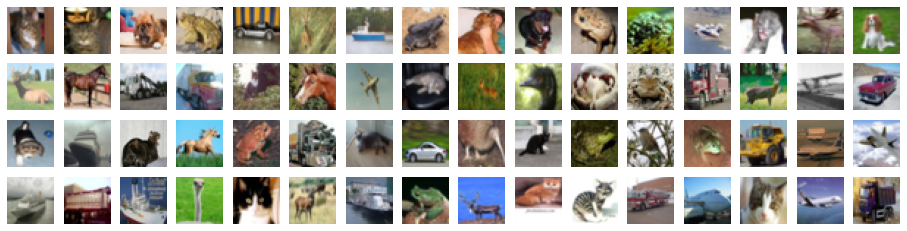

In [6]:
def plot_batch(batch):
    plt.figure(figsize=(16, 4))
    n_images = 64
    plot_batch = tf.cast(deprocess(batch), tf.uint8)
    for i in range(n_images):
        plt.subplot(4, 16, i+1)
        plt.imshow(plot_batch[i, :, :, :])
        plt.axis('off')
    plt.show()
     
plot_batch(train_batch)

## 2.- Modelo
### Generador
- Define bloque para UpSampling

In [7]:
def upBlock(filters, kernel_size=3, initializer='orthogonal'):
    block = tf.keras.Sequential([
            layers.UpSampling2D(2),
            layers.Conv2D(filters*2, kernel_size=kernel_size, 
                padding='same', use_bias=False,
                kernel_initializer=initializer),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2)
    ])
    return block

In [8]:
class Generator(tf.keras.models.Model):
    def __init__(self, filters=128, dense_units=512, initializer='glorot_uniform'):
        super(Generator, self).__init__()
        self.init = tf.keras.Sequential([
            layers.Dense(4 * 4 * dense_units, 
                         use_bias=False, kernel_initializer=initializer),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
            layers.Reshape((4, 4, dense_units))
        ])     
        self.up_8 = upBlock(filters, initializer=initializer)
        self.up_16 = upBlock(filters // 2, initializer=initializer)
        self.up_32 = upBlock(filters // 4, initializer=initializer)
        self.ch_conv = layers.Conv2D(3, 3, padding='same', 
                                     activation='tanh', kernel_initializer=initializer)      
                       
    def call(self, z):
        feat_4 = self.init(z)
        feat_8 = self.up_8(feat_4)  
        feat_16 = self.up_16(feat_8)
        feat_32 = self.up_32(feat_16)
        img = self.ch_conv(feat_32)
        return img

    
noise_dim = 64
noise = tf.random.normal([batch_size, noise_dim])
generator = Generator(64, 64)

In [9]:
gen_batch = generator(noise)
generator.summary()
print(gen_batch.shape)

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (128, 4, 4, 64)           69632     
                                                                 
 sequential_1 (Sequential)   (128, 8, 8, 128)          74240     
                                                                 
 sequential_2 (Sequential)   (128, 16, 16, 64)         73984     
                                                                 
 sequential_3 (Sequential)   (128, 32, 32, 32)         18560     
                                                                 
 conv2d_3 (Conv2D)           multiple                  867       
                                                                 
Total params: 237,283
Trainable params: 234,787
Non-trainable params: 2,496
_________________________________________________________________
(128, 32, 32, 3)


### Discriminador

- Define bloque residual

In [10]:
def convBlock(filters, kernel_size=3, strides=1, padding='same', 
              use_bias=False, kernel_initializer='orthogonal', use_bn=True):
    if use_bn:
        block = tf.keras.Sequential([
            layers.Conv2D(filters, kernel_size=kernel_size, strides=strides,
                padding='same', use_bias=use_bias, kernel_initializer=kernel_initializer),
            layers.BatchNormalization()
         ])
    else:
        block = layers.Conv2D(filters, kernel_size=kernel_size, strides=strides, 
                padding='same', use_bias=use_bias, kernel_initializer=kernel_initializer)
    return block

In [11]:
class DownBlockComp(layers.Layer):
    def __init__(self, filters, initializer='orthogonal', use_bn=True):
        super(DownBlockComp, self).__init__()

        self.main = tf.keras.Sequential([
            convBlock(filters, kernel_size=4, padding='same',
                strides=2, use_bias=False, kernel_initializer=initializer, use_bn=use_bn),
            layers.LeakyReLU(0.2),
            convBlock(filters, kernel_size=3, padding='same',
                use_bias=False, kernel_initializer=initializer, use_bn=use_bn),
            layers.LeakyReLU(0.2),
        ])
        
        self.direct = tf.keras.Sequential([
            layers.AveragePooling2D((2, 2)),
            convBlock(filters, kernel_size=1, padding='same',
                use_bias=False, kernel_initializer=initializer, use_bn=use_bn),
            layers.LeakyReLU(0.2),
        ])

    def call(self, x):
        return (self.main(x) + self.direct(x)) / 2

In [12]:
class Discriminator(tf.keras.models.Model):
    def __init__(self, filters=128, initializer='orthogonal', use_bn=True):
        super(Discriminator, self).__init__()
        '''Encode image'''
        self.down_from_big = tf.keras.Sequential([
            layers.Conv2D(filters // 4, kernel_size=3, padding='same', 
                use_bias=False, kernel_initializer=initializer),
            layers.LeakyReLU(0.2)
        ])
        self.down_16 = DownBlockComp(filters // 2, initializer=initializer, use_bn=use_bn)
        self.down_8 = DownBlockComp(filters, initializer=initializer, use_bn=use_bn)

        '''Logits'''
        self.logits = tf.keras.Sequential([
            layers.Conv2D(filters, kernel_size=1, padding='valid', 
                use_bias=False, kernel_initializer=initializer),  
            layers.LeakyReLU(0.2),
            layers.Conv2D(1, kernel_size=4, padding='valid', 
                use_bias=False, kernel_initializer=initializer), 
            layers.Flatten()
        ])
 
    def call(self, img):
        feat_32 = self.down_from_big(img)
        feat_16 = self.down_16(feat_32)
        feat_8 = self.down_8(feat_16)

        logits = self.logits(feat_8)
        return logits
    
    
discriminator = Discriminator(128, use_bn=False)
out_disc = discriminator(train_batch)
discriminator.summary()
out_disc.shape

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (128, 32, 32, 32)         864       
                                                                 
 down_block_comp (DownBlockC  multiple                 71680     
 omp)                                                            
                                                                 
 down_block_comp_1 (DownBloc  multiple                 286720    
 kComp)                                                          
                                                                 
 sequential_9 (Sequential)   (128, 25)                 18432     
                                                                 
Total params: 377,696
Trainable params: 377,696
Non-trainable params: 0
_________________________________________________________________


TensorShape([128, 25])

## 3.- Entrenamiento
- Define funciones de pérdida y optimizadores

In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [14]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [15]:
g_lr = 0.0001
d_lr = 0.0001
beta_1 = 0.5
beta_2 = 0.9

g_opt = tf.keras.optimizers.Adam(learning_rate=g_lr, 
                                 beta_1=beta_1, 
                                 beta_2=beta_2)

d_opt = tf.keras.optimizers.Adam(learning_rate=d_lr, 
                                 beta_1=beta_1,
                                 beta_2=beta_2)

- Define GAN

In [16]:
class GAN(tf.keras.models.Model):
    def __init__(self, generator, discriminator, g_opt, d_opt, g_loss, d_loss):
        super(GAN, self).__init__()
        self.generator = generator
        self.g_opt = g_opt
        self.g_loss = g_loss
        self.discriminator = discriminator
        self.d_opt = d_opt
        self.d_loss = d_loss
        
        # Log metrics
        self.g_loss_avg = tf.keras.metrics.Mean()
        self.d_loss_avg = tf.keras.metrics.Mean()

    @tf.function
    def train_step(self, real_img):
        noise = tf.random.normal([batch_size, noise_dim])

        with tf.GradientTape() as disc_tape:
            gen_img = self.generator(noise, training=True)
            real_out = self.discriminator(real_img, training=True)
            fake_out = self.discriminator(gen_img, training=True)

            disc_loss = self.d_loss(real_out, fake_out)

        disc_gradients = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(disc_gradients, self.discriminator.trainable_variables)) 

        noise = tf.random.normal([batch_size, noise_dim])

        # Train the generator
        with tf.GradientTape() as gen_tape:
            generator_output = self.generator(noise, training=True)
            fake_out = self.discriminator(generator_output, training=True)

            gen_loss = self.g_loss(fake_out)

        gen_gradients = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(gen_gradients, self.generator.trainable_variables))
        
        self.g_loss_avg(gen_loss)
        self.d_loss_avg(disc_loss)

- Define modelo

In [17]:
gan = GAN(generator, discriminator, 
          g_opt, d_opt, 
          generator_loss, discriminator_loss)

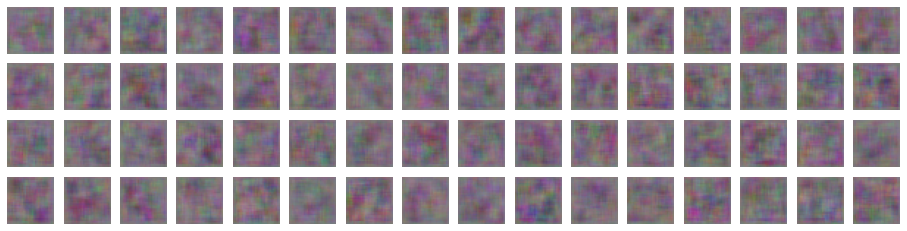

In [18]:
noise = tf.random.normal([batch_size, noise_dim])
gen_batch = gan.generator(noise)

plot_batch(gen_batch)

In [19]:
noise_seed = tf.random.normal([batch_size, noise_dim])

In [20]:
epochs = 50
plot_inter = 10

def train(model, epochs, plot_inter):
    for epoch in range(epochs):
        start = time.time()
        for image_batch in train_dataset:
            model.train_step(image_batch)

        g_loss = model.g_loss_avg.result()
        d_loss = model.d_loss_avg.result()
        print(f'Time for epoch {epoch} is {time.time()-start:.4f} sec G loss: {g_loss:.4f} D loss: {d_loss:.4f}')
        if epoch % plot_inter == 0:
            gen_batch = model.generator(noise_seed, training=False)
            plot_batch(gen_batch)
            
        model.g_loss_avg.reset_states()
        model.d_loss_avg.reset_states()

Time for epoch 0 is 7.9384 sec G loss: 0.9108 D loss: 1.2731


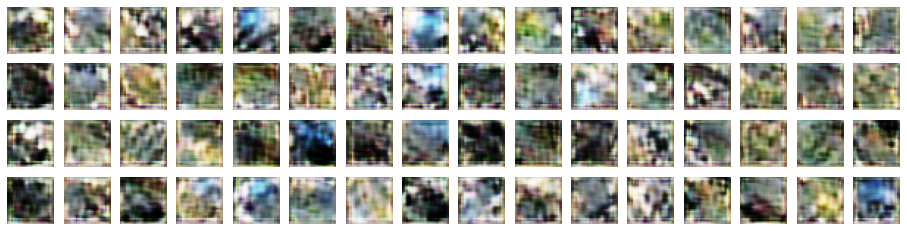

Time for epoch 1 is 5.9122 sec G loss: 0.7267 D loss: 1.3412
Time for epoch 2 is 5.9297 sec G loss: 0.7406 D loss: 1.3493
Time for epoch 3 is 5.9579 sec G loss: 0.7247 D loss: 1.3443
Time for epoch 4 is 5.9580 sec G loss: 0.7197 D loss: 1.3410
Time for epoch 5 is 5.9651 sec G loss: 0.7251 D loss: 1.3233
Time for epoch 6 is 5.9544 sec G loss: 0.7365 D loss: 1.3083
Time for epoch 7 is 5.9698 sec G loss: 0.7386 D loss: 1.3092
Time for epoch 8 is 5.9774 sec G loss: 0.7517 D loss: 1.3022
Time for epoch 9 is 5.9690 sec G loss: 0.7469 D loss: 1.3070
Time for epoch 10 is 5.9662 sec G loss: 0.7398 D loss: 1.3082


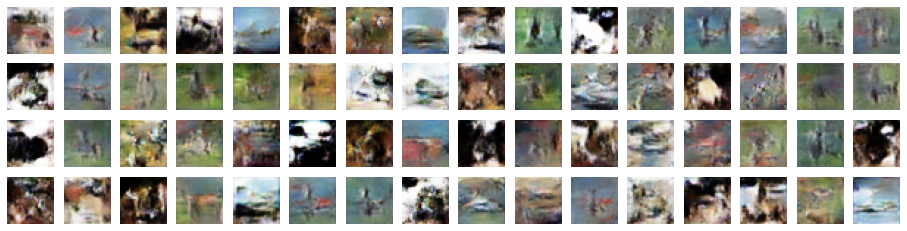

Time for epoch 11 is 5.9583 sec G loss: 0.7393 D loss: 1.3024
Time for epoch 12 is 5.9719 sec G loss: 0.7453 D loss: 1.2913
Time for epoch 13 is 6.0678 sec G loss: 0.7506 D loss: 1.2799
Time for epoch 14 is 6.0369 sec G loss: 0.7565 D loss: 1.2657
Time for epoch 15 is 6.1148 sec G loss: 0.7547 D loss: 1.2551
Time for epoch 16 is 6.0600 sec G loss: 0.7507 D loss: 1.2526
Time for epoch 17 is 5.9732 sec G loss: 0.7576 D loss: 1.2525
Time for epoch 18 is 5.9699 sec G loss: 0.7648 D loss: 1.2538
Time for epoch 19 is 5.9565 sec G loss: 0.7592 D loss: 1.2513
Time for epoch 20 is 5.9621 sec G loss: 0.7521 D loss: 1.2536


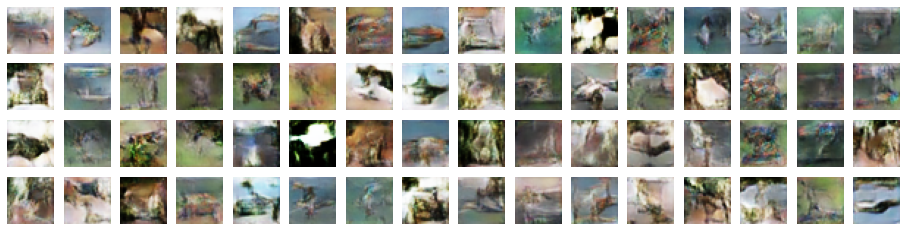

Time for epoch 21 is 5.9592 sec G loss: 0.7532 D loss: 1.2567
Time for epoch 22 is 5.9561 sec G loss: 0.7504 D loss: 1.2608
Time for epoch 23 is 5.9619 sec G loss: 0.7477 D loss: 1.2560
Time for epoch 24 is 5.9715 sec G loss: 0.7501 D loss: 1.2580
Time for epoch 25 is 5.9669 sec G loss: 0.7493 D loss: 1.2547
Time for epoch 26 is 5.9783 sec G loss: 0.7498 D loss: 1.2535
Time for epoch 27 is 5.9705 sec G loss: 0.7495 D loss: 1.2508
Time for epoch 28 is 5.9615 sec G loss: 0.7507 D loss: 1.2488
Time for epoch 29 is 5.9534 sec G loss: 0.7566 D loss: 1.2467
Time for epoch 30 is 5.9393 sec G loss: 0.7495 D loss: 1.2411


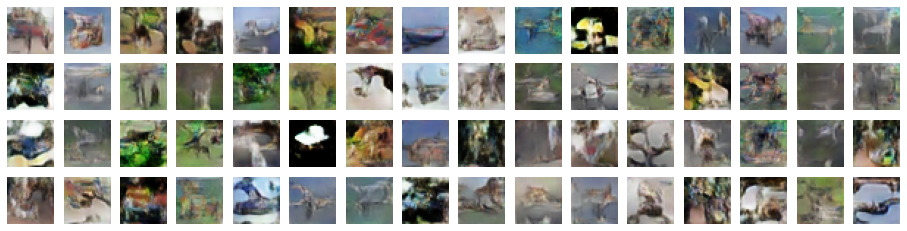

Time for epoch 31 is 6.0013 sec G loss: 0.7464 D loss: 1.2423
Time for epoch 32 is 5.9564 sec G loss: 0.7428 D loss: 1.2401
Time for epoch 33 is 5.9475 sec G loss: 0.7441 D loss: 1.2370
Time for epoch 34 is 5.9658 sec G loss: 0.7448 D loss: 1.2296
Time for epoch 35 is 5.9632 sec G loss: 0.7435 D loss: 1.2248
Time for epoch 36 is 5.9650 sec G loss: 0.7394 D loss: 1.2228
Time for epoch 37 is 5.9583 sec G loss: 0.7422 D loss: 1.2168
Time for epoch 38 is 5.9494 sec G loss: 0.7403 D loss: 1.2119
Time for epoch 39 is 5.9461 sec G loss: 0.7394 D loss: 1.2034
Time for epoch 40 is 5.9573 sec G loss: 0.7406 D loss: 1.1980


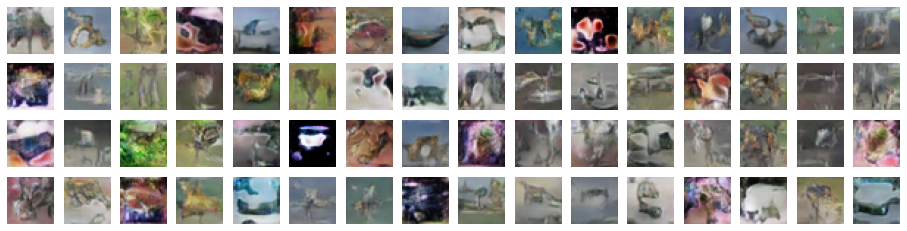

Time for epoch 41 is 6.0447 sec G loss: 0.7425 D loss: 1.1934
Time for epoch 42 is 6.0169 sec G loss: 0.7394 D loss: 1.1931
Time for epoch 43 is 5.9581 sec G loss: 0.7399 D loss: 1.1906
Time for epoch 44 is 6.0095 sec G loss: 0.7403 D loss: 1.1861
Time for epoch 45 is 5.9602 sec G loss: 0.7400 D loss: 1.1843
Time for epoch 46 is 6.0938 sec G loss: 0.7423 D loss: 1.1864
Time for epoch 47 is 6.0805 sec G loss: 0.7459 D loss: 1.1852
Time for epoch 48 is 6.0013 sec G loss: 0.7462 D loss: 1.1771
Time for epoch 49 is 5.9821 sec G loss: 0.7471 D loss: 1.1732


In [21]:
train(gan, epochs, plot_inter)

- Normalizando en el discriminador

Time for epoch 0 is 8.1584 sec G loss: 1.0444 D loss: 1.0417


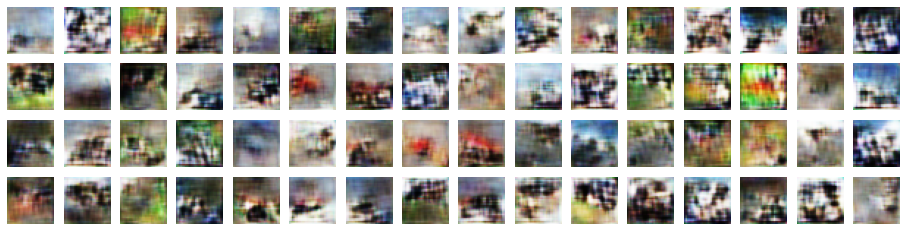

Time for epoch 1 is 6.4900 sec G loss: 1.2108 D loss: 0.9528
Time for epoch 2 is 6.4978 sec G loss: 1.3587 D loss: 0.8637
Time for epoch 3 is 6.5281 sec G loss: 1.4610 D loss: 0.8230
Time for epoch 4 is 6.5684 sec G loss: 1.4688 D loss: 0.8515
Time for epoch 5 is 6.5444 sec G loss: 1.5366 D loss: 0.7956
Time for epoch 6 is 6.5276 sec G loss: 1.5365 D loss: 0.7952
Time for epoch 7 is 6.5029 sec G loss: 1.6014 D loss: 0.7858
Time for epoch 8 is 6.7197 sec G loss: 1.6272 D loss: 0.7901
Time for epoch 9 is 6.6222 sec G loss: 1.6211 D loss: 0.7953
Time for epoch 10 is 6.6407 sec G loss: 1.6598 D loss: 0.7929


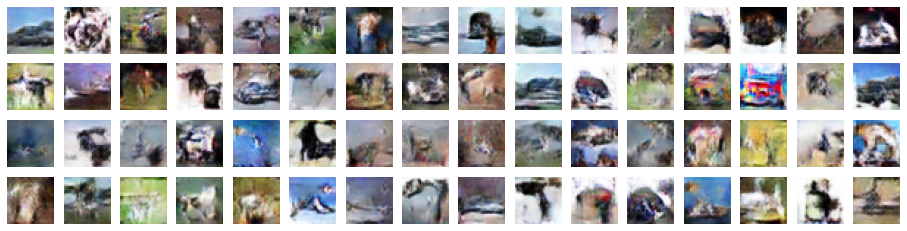

Time for epoch 11 is 6.5111 sec G loss: 1.6329 D loss: 0.8037
Time for epoch 12 is 6.5225 sec G loss: 1.6393 D loss: 0.8218
Time for epoch 13 is 6.5959 sec G loss: 1.6001 D loss: 0.8430
Time for epoch 14 is 6.5248 sec G loss: 1.6111 D loss: 0.8496
Time for epoch 15 is 6.5055 sec G loss: 1.6186 D loss: 0.8652
Time for epoch 16 is 6.5141 sec G loss: 1.6182 D loss: 0.8642
Time for epoch 17 is 6.4967 sec G loss: 1.6093 D loss: 0.8620
Time for epoch 18 is 6.4983 sec G loss: 1.6022 D loss: 0.8707
Time for epoch 19 is 6.5075 sec G loss: 1.6333 D loss: 0.8482
Time for epoch 20 is 6.5054 sec G loss: 1.6443 D loss: 0.8407


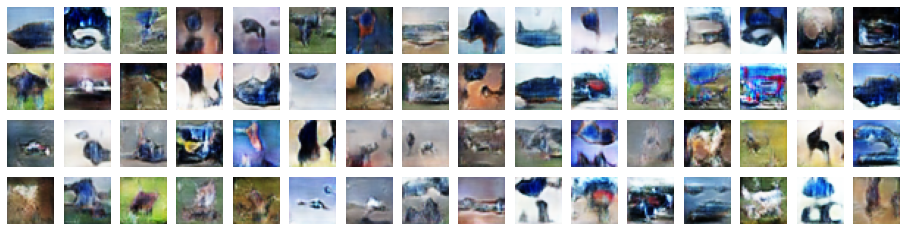

Time for epoch 21 is 6.6503 sec G loss: 1.6853 D loss: 0.8297
Time for epoch 22 is 6.6311 sec G loss: 1.6856 D loss: 0.8175
Time for epoch 23 is 6.7413 sec G loss: 1.7199 D loss: 0.8097
Time for epoch 24 is 6.7663 sec G loss: 1.7265 D loss: 0.8008
Time for epoch 25 is 6.6799 sec G loss: 1.7422 D loss: 0.8022
Time for epoch 26 is 6.7187 sec G loss: 1.7370 D loss: 0.8150
Time for epoch 27 is 6.6225 sec G loss: 1.7613 D loss: 0.7976
Time for epoch 28 is 6.5756 sec G loss: 1.7366 D loss: 0.7929
Time for epoch 29 is 6.6709 sec G loss: 1.7374 D loss: 0.7847
Time for epoch 30 is 6.5113 sec G loss: 1.8125 D loss: 0.7753


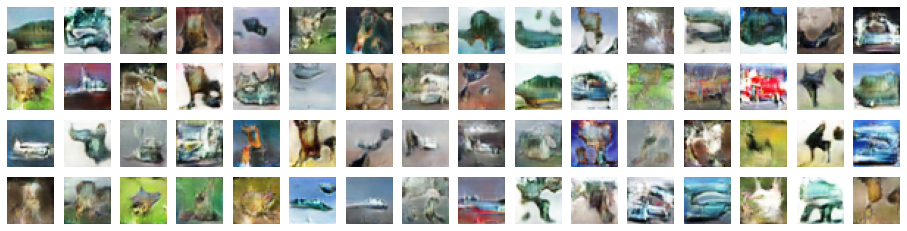

Time for epoch 31 is 6.4963 sec G loss: 1.8158 D loss: 0.7783
Time for epoch 32 is 6.5146 sec G loss: 1.8560 D loss: 0.7788
Time for epoch 33 is 6.5080 sec G loss: 1.8293 D loss: 0.7673
Time for epoch 34 is 6.5229 sec G loss: 1.8625 D loss: 0.7720
Time for epoch 35 is 6.5534 sec G loss: 1.8885 D loss: 0.7528
Time for epoch 36 is 6.5239 sec G loss: 1.9118 D loss: 0.7575
Time for epoch 37 is 6.5319 sec G loss: 1.9485 D loss: 0.7391
Time for epoch 38 is 6.6275 sec G loss: 1.9300 D loss: 0.7494
Time for epoch 39 is 6.5168 sec G loss: 2.0022 D loss: 0.7372
Time for epoch 40 is 6.6164 sec G loss: 1.9766 D loss: 0.7335


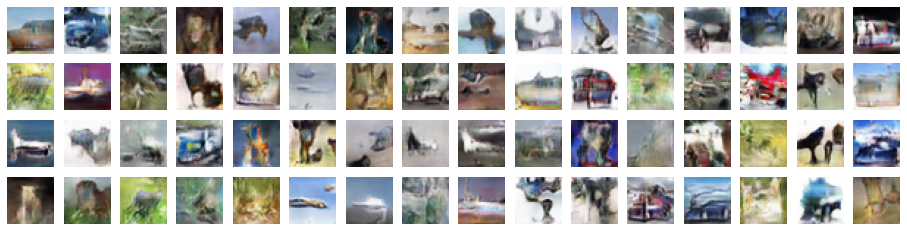

Time for epoch 41 is 6.5944 sec G loss: 1.9712 D loss: 0.7415
Time for epoch 42 is 6.5649 sec G loss: 2.0002 D loss: 0.7290
Time for epoch 43 is 6.5152 sec G loss: 1.9956 D loss: 0.7267
Time for epoch 44 is 6.5101 sec G loss: 2.0498 D loss: 0.7065
Time for epoch 45 is 6.5188 sec G loss: 2.0545 D loss: 0.7118
Time for epoch 46 is 6.5205 sec G loss: 2.0921 D loss: 0.7267
Time for epoch 47 is 6.4973 sec G loss: 2.0964 D loss: 0.7199
Time for epoch 48 is 6.5139 sec G loss: 2.1061 D loss: 0.7069
Time for epoch 49 is 6.5084 sec G loss: 2.1552 D loss: 0.6990


In [22]:
g_opt = tf.keras.optimizers.Adam(learning_rate=g_lr, 
                                 beta_1=beta_1, 
                                 beta_2=beta_2)

d_opt = tf.keras.optimizers.Adam(learning_rate=d_lr, 
                                 beta_1=beta_1,
                                 beta_2=beta_2)

generator = Generator(64, 128)
discriminator = Discriminator(128, use_bn=True)

gan = GAN(generator, discriminator, 
            g_opt, d_opt, 
            generator_loss, discriminator_loss)

train(gan, epochs, plot_inter)

- WGAN

In [23]:
def w_discriminator_loss(real_output, fake_output):
    real_loss = tf.reduce_mean(real_output)
    fake_loss = tf.reduce_mean(fake_output)
    return fake_loss - real_loss

def w_generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

Time for epoch 0 is 8.1899 sec G loss: 11.2998 D loss: -5.0606


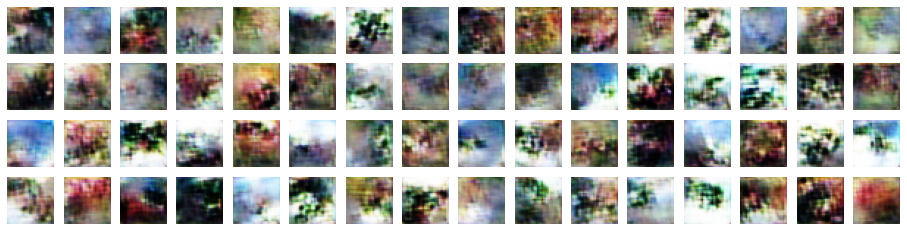

Time for epoch 1 is 6.6307 sec G loss: 64.6862 D loss: -28.0249
Time for epoch 2 is 6.5203 sec G loss: 170.4746 D loss: -78.4257
Time for epoch 3 is 6.5170 sec G loss: 345.3754 D loss: -189.3269
Time for epoch 4 is 6.5160 sec G loss: 608.3656 D loss: -366.0237
Time for epoch 5 is 6.5073 sec G loss: 952.9861 D loss: -569.1487
Time for epoch 6 is 6.5196 sec G loss: 1394.8888 D loss: -866.5589
Time for epoch 7 is 6.5426 sec G loss: 1938.4469 D loss: -1171.8364
Time for epoch 8 is 6.5207 sec G loss: 2724.8420 D loss: -1620.2269
Time for epoch 9 is 6.5191 sec G loss: 3438.8862 D loss: -1899.2721
Time for epoch 10 is 6.5197 sec G loss: 4351.3921 D loss: -2434.8220


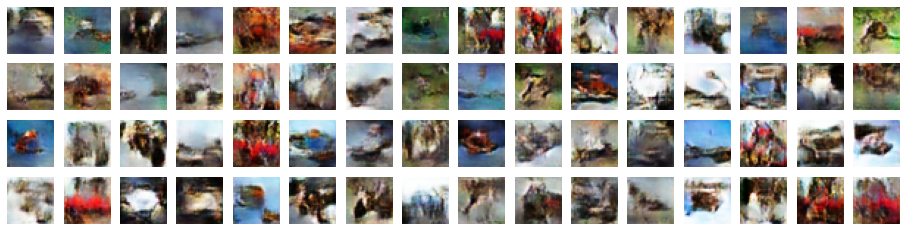

Time for epoch 11 is 6.5425 sec G loss: 5539.8633 D loss: -3107.8931
Time for epoch 12 is 6.5654 sec G loss: 6899.6274 D loss: -4052.4106
Time for epoch 13 is 6.5511 sec G loss: 8367.1807 D loss: -5102.6909
Time for epoch 14 is 6.7097 sec G loss: 9931.6074 D loss: -6075.3018
Time for epoch 15 is 10.6647 sec G loss: 12082.0889 D loss: -7303.9771
Time for epoch 16 is 6.7516 sec G loss: 14151.9727 D loss: -8337.6953
Time for epoch 17 is 6.6714 sec G loss: 16592.7617 D loss: -9711.1992
Time for epoch 18 is 6.6161 sec G loss: 18990.4727 D loss: -10634.7607
Time for epoch 19 is 6.6634 sec G loss: 22302.9727 D loss: -13290.4346
Time for epoch 20 is 6.6465 sec G loss: 25340.5273 D loss: -14622.1768


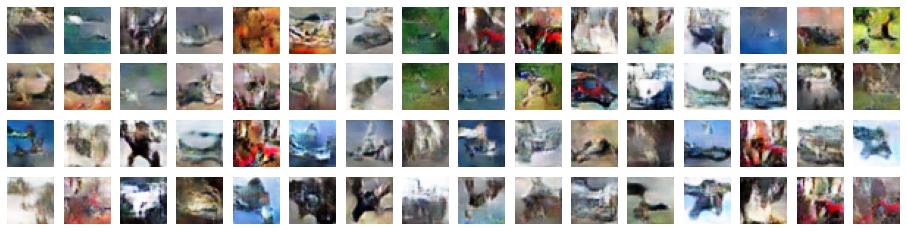

Time for epoch 21 is 6.7107 sec G loss: 28282.3711 D loss: -16190.1465
Time for epoch 22 is 6.5860 sec G loss: 32238.0820 D loss: -18345.5977
Time for epoch 23 is 6.5920 sec G loss: 37071.3477 D loss: -20184.3555
Time for epoch 24 is 6.5954 sec G loss: 42271.1680 D loss: -25158.7598
Time for epoch 25 is 6.5956 sec G loss: 47375.1641 D loss: -27629.4199
Time for epoch 26 is 6.5807 sec G loss: 52501.7422 D loss: -31539.9746
Time for epoch 27 is 6.5887 sec G loss: 58248.1602 D loss: -33550.6680
Time for epoch 28 is 6.5897 sec G loss: 65134.3477 D loss: -39555.2695
Time for epoch 29 is 6.5891 sec G loss: 70518.9141 D loss: -43303.2266
Time for epoch 30 is 6.5858 sec G loss: 78998.4531 D loss: -49281.6172


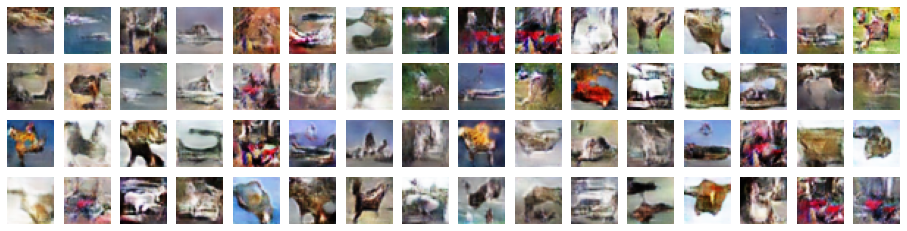

Time for epoch 31 is 6.5813 sec G loss: 88532.3984 D loss: -56076.8242
Time for epoch 32 is 6.5975 sec G loss: 96871.8438 D loss: -62033.9453
Time for epoch 33 is 6.5841 sec G loss: 105939.6719 D loss: -67606.1328
Time for epoch 34 is 6.5878 sec G loss: 114213.6172 D loss: -71956.5859
Time for epoch 35 is 6.5832 sec G loss: 122852.5859 D loss: -78956.7031
Time for epoch 36 is 6.5855 sec G loss: 132257.7656 D loss: -84065.0078
Time for epoch 37 is 6.6043 sec G loss: 144375.8125 D loss: -95079.1406
Time for epoch 38 is 6.6087 sec G loss: 158015.8438 D loss: -104614.5781
Time for epoch 39 is 6.6014 sec G loss: 172237.6562 D loss: -115672.4141
Time for epoch 40 is 6.5877 sec G loss: 180651.7969 D loss: -121040.3672


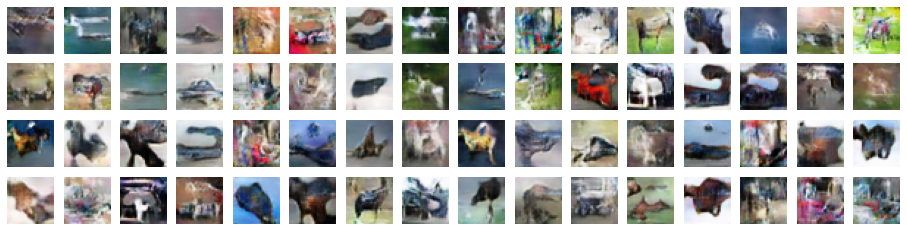

Time for epoch 41 is 6.5863 sec G loss: 197407.8125 D loss: -133078.7344
Time for epoch 42 is 6.6140 sec G loss: 213381.4531 D loss: -140427.0156
Time for epoch 43 is 6.5995 sec G loss: 225514.5781 D loss: -152010.7500
Time for epoch 44 is 6.7595 sec G loss: 245862.3750 D loss: -168095.3906
Time for epoch 45 is 6.7267 sec G loss: 259375.3906 D loss: -178320.7344
Time for epoch 46 is 6.5631 sec G loss: 279313.6875 D loss: -196756.1250
Time for epoch 47 is 6.5728 sec G loss: 300609.2812 D loss: -204597.9062
Time for epoch 48 is 6.5396 sec G loss: 327049.4062 D loss: -223030.7344
Time for epoch 49 is 6.5319 sec G loss: 339378.0312 D loss: -237527.5469


In [24]:
g_opt_clip = tf.keras.optimizers.Adam(learning_rate=g_lr, 
                                 beta_1=beta_1, 
                                 beta_2=beta_2,
                                 clipvalue=1.0)

d_opt_clip = tf.keras.optimizers.Adam(learning_rate=d_lr, 
                                 beta_1=beta_1,
                                 beta_2=beta_2,
                                 clipvalue=1.0)

generator_clip = Generator(64, 128)
discriminator_clip = Discriminator(128, use_bn=True)

wgan = GAN(generator_clip, discriminator_clip, 
            g_opt_clip, d_opt_clip, 
            w_generator_loss, w_discriminator_loss)

train(wgan, epochs, plot_inter)